In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('hotel_cleaned_data_set_final_for_model.csv')
df.head()
df.shape

(118981, 35)

In [ ]:
df1 = df.sample(frac=0.5)
df1.shape

(59490, 35)

In [ ]:
df1['is_canceled'].value_counts(normalize=True)


0    0.628475
1    0.371525
Name: is_canceled, dtype: float64

# X/y Split and Mteric Selection

In [ ]:
X = df1.drop(['is_canceled'], axis = 1)
y = df1['is_canceled']

To select the appropriate evaluation metric, we need to understand about the risk of false negative and false positive in our prediction case. In short term point-of-view (POV), false negative of booking cancellation prediction is more likely resulting in profit-loss because of unnecessary preparation of the hotel towards non-existent customer. But in the long term POV, failing to prepare for the customer's arrival also will reduce our customer's experience, resulting in unseen profit/opportunity-loss in the future (false positive). So, balancing false positive and false negative (F1 score) is necessity for this prediction model building.

Thus we select F1 score as our performance metric in addition to accuracy (primary)

# Balancing Method


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier


In [ ]:
def balance_train_data(X, y, method=None):
    '''
    Balances the data passed in according to the specified method.
    Returns balanced numpy arrays.
    '''
    if method == None:
        return X, y

    elif method == 'undersampling':
        rus = RandomUnderSampler()
        X_train, y_train = rus.fit_resample(X, y)
        return X_train, y_train

    elif method == 'oversampling':
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_resample(X, y)
        return X_train, y_train

    elif method == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X, y)
        return X_train, y_train

    elif method == 'both':
        smote = SMOTE(sampling_strategy=0.75)
        under = RandomUnderSampler(sampling_strategy=1)
        X_train, y_train = smote.fit_resample(X, y)
        X_train, y_train = under.fit_resample(X_train, y_train)
        return X_train, y_train

    else:
        print('Incorrect balance method')
        return

In [ ]:
def plot_cross_val(models, X, y, ax, sampling_method, names, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)


    precisions = []
    recalls = []
    f1 = []
    for i in range(len(models)):
        precisions.append([])
        recalls.append([])
        f1.append([])

    for train, test in kf.split(X):
        X_test, y_test = X.iloc[test], y.iloc[test]
        X_train, y_train = X.iloc[train], y.iloc[train]
        
        X_train, y_train = balance_train_data(X_train, y_train, method=sampling_method)

        for i, model in enumerate(models):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # precisions[i].append(precision_score(y_test, y_pred))
            # recalls[i].append(recall_score(y_test, y_pred))
            f1[i].append(f1_score(y_test, y_pred))

    x = range(0, n_splits)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g',
                3 : 'c',
                4 : 'm'}


    for i in range(len(models)):
        print(f1[i])
        ax.plot(x, f1[i], c=colormap[i],
                linewidth=1, linestyle='-',
                label='%s F1 Score' % names[i])
        # ax.plot(x, precisions[i], c=colormap[i],
        #        linewidth=1, linestyle='-',
        #        label='%s Precision' % names[i])
        # ax.plot(x, recalls[i], c=colormap[i],
        #        linewidth=1, linestyle='--',
        #        label='%s Recall' % names[i])

To find the effect of balancing will use logistic regression as our basic binary classification model, KNN as instance-based machine learning model, Forest as bagging ensemble method, and XGBoost as boosting ensemble method.

In [ ]:
models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]


[0.699340488814173, 0.6690830984024702, 0.6814345991561181, 0.6675775379150157, 0.6823932525039537]
[0.6470935031246315, 0.6458706824429306, 0.632010613918707, 0.6287104622871046, 0.6462241462241461]
[0.7812199807877042, 0.7822415249125346, 0.7762934175370416, 0.7777228945418623, 0.7854241338112306]
[0.7111400651465798, 0.702322495023225, 0.70996699669967, 0.7024693023883417, 0.7136746597537265]


Text(0.5, 1.0, 'No Balancing')

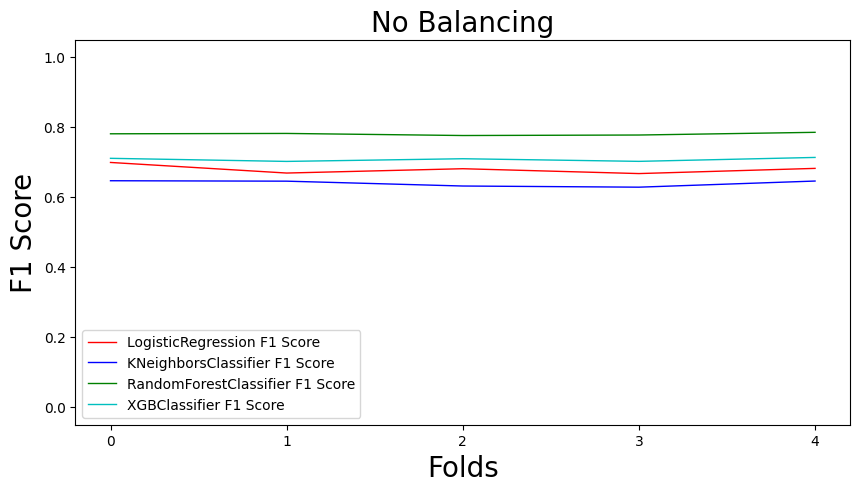

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_cross_val(models, X, y, ax, None, [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('No Balancing', fontsize=20)



[0.707492000441355, 0.6929010620458356, 0.6972943125345112, 0.7003040882982318, 0.7044607566346697]
[0.644868301544051, 0.6438652518800866, 0.646141130282054, 0.6353790613718411, 0.6442307692307693]
[0.780418665503707, 0.7758678052567373, 0.7791601866251944, 0.784536541889483, 0.7883936451897617]
[0.7259637714816535, 0.7151921465341794, 0.7242857142857142, 0.7302678359800902, 0.7295256077413265]


Text(0.5, 1.0, 'Undersampling')

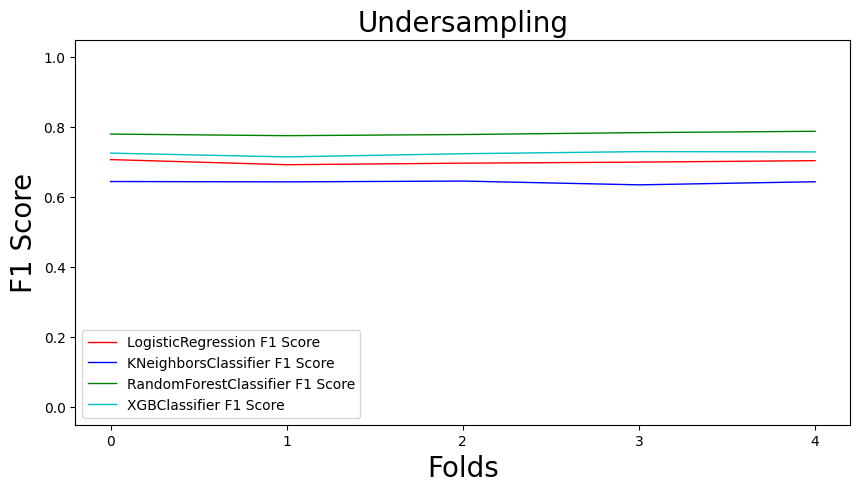

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'undersampling', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('Undersampling', fontsize=20)

[0.7019372380197122, 0.7015600271309066, 0.7136243386243386, 0.6914606741573034, 0.6976585587633553]
[0.6548013245033113, 0.6538661131292164, 0.6568326162671584, 0.6421272158498436, 0.6415294742432289]
[0.7833528722157093, 0.7793305930710511, 0.7931509997701678, 0.7788686302010285, 0.7787969029184038]
[0.7292529892269445, 0.7233136094674557, 0.7366102480871785, 0.7220386974988202, 0.7246236036911122]


Text(0.5, 1.0, 'Oversampling')

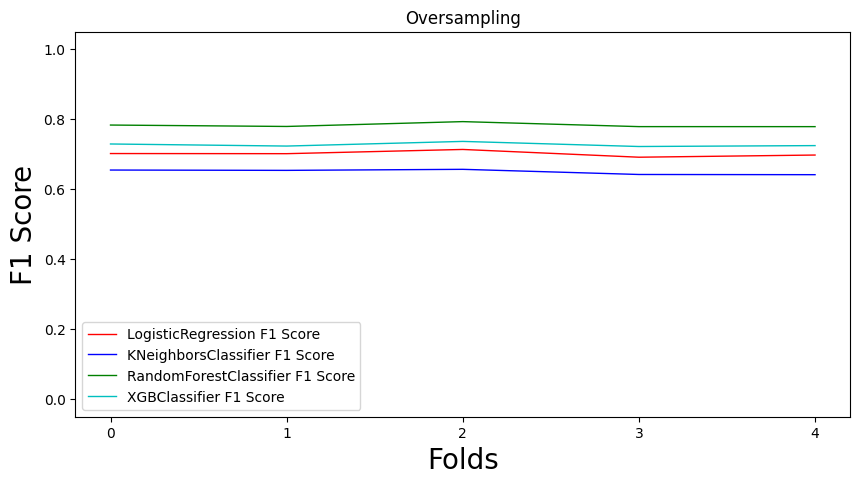

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'oversampling', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('Oversampling')

[0.6983035304906006, 0.6989871400933196, 0.6985123198512321, 0.7012097694590276, 0.6973790555363122]
[0.6544926333264163, 0.6444650015417823, 0.6487738132828124, 0.6519234725365152, 0.6563602407138411]
[0.7796650717703351, 0.7794169715567096, 0.7844489359172513, 0.7842865395725014, 0.7862215909090908]
[0.7174202933688932, 0.7210507290034943, 0.7238164426686039, 0.7284345047923323, 0.7204457364341086]


Text(0.5, 1.0, 'SMOTE')

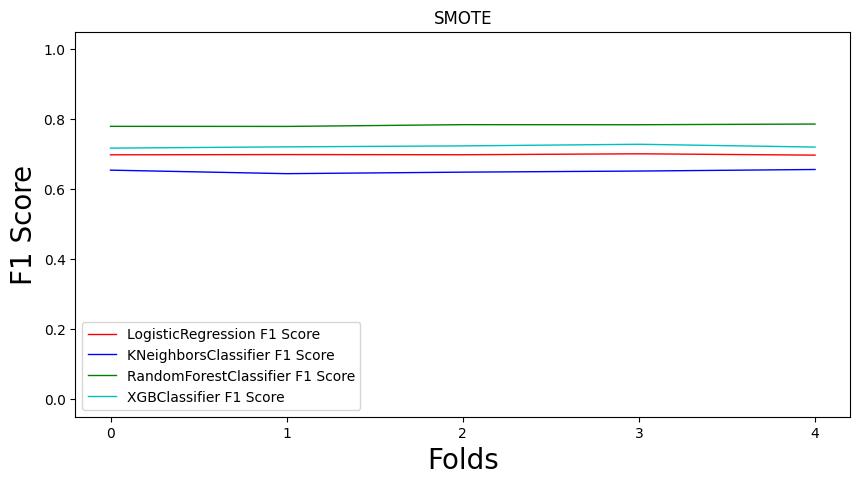

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'smote', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('SMOTE')

[0.6909132368031011, 0.6952606101542271, 0.7023056057866185, 0.7075089928057554, 0.700957213700842]
[0.6395288769500981, 0.6433697347893915, 0.6501484590969592, 0.6523209345219798, 0.6458964976476739]
[0.7714514835605454, 0.7875588201537932, 0.7840717891194616, 0.7867160327611354, 0.7782628676470588]
[0.7143198090692123, 0.7227876900969944, 0.727663640707119, 0.7311039853412735, 0.7247177516214267]


Text(0.5, 1.0, 'SMOTE + Undersampling')

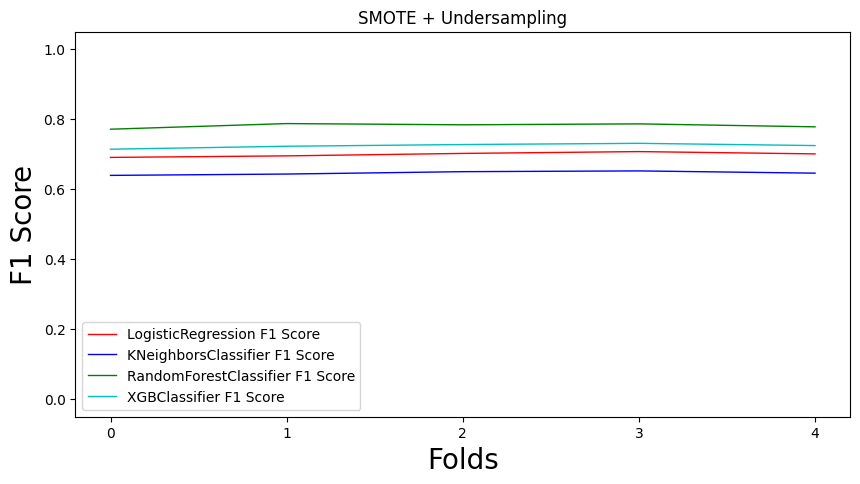

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_cross_val(models, X, y, ax, 'both', [m.__class__.__name__ for m in models])
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xlabel('Folds', fontsize=20)
ax.set_ylabel('F1 Score', fontsize=20)
ax.set_title('SMOTE + Undersampling')

Not balancing the data actually doesn't make much of a difference, so I decided to move forward with the data as is. It is likely that this is the case because the data is not too imbalanced.

# Train/Test Split

In [ ]:
# Train and test split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,stratify = y,test_size = 0.30)

# Model Building

### XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier()

In [ ]:
training_acc_xgb=xgb.score(X_train,y_train)
testing_acc_xgb=xgb.score(X_test,y_test)

y_predicted=xgb.predict(X_test)

recall_xgb=recall_score(y_test,y_predicted)
accuracy_xgb=accuracy_score(y_test,y_predicted)
precision_xgb=precision_score(y_test,y_predicted)
f1_xgb=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_xgb}")
print(f"Testing Accuracy : {testing_acc_xgb}")

#Model is not over or under fitting

Training Accuracy : 0.8138462646783373
Testing Accuracy : 0.8189051381184512


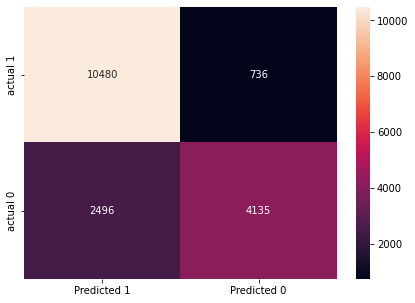

In [ ]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87     11216
           1       0.85      0.62      0.72      6631

    accuracy                           0.82     17847
   macro avg       0.83      0.78      0.79     17847
weighted avg       0.82      0.82      0.81     17847



### LGB

In [214]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train,y_train)

LGBMClassifier()

In [215]:
training_acc_lgb=lgb_model.score(X_train,y_train)
testing_acc_lgb=lgb_model.score(X_test,y_test)

y_predicted=lgb_model.predict(X_test)

recall_lgb=recall_score(y_test,y_predicted)
accuracy_lgb=accuracy_score(y_test,y_predicted)
precision_lgb=precision_score(y_test,y_predicted)
f1_lgb=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_lgb}")
print(f"Testing Accuracy : {testing_acc_lgb}")

#Model is not overfitting or underfitting

Training Accuracy : 0.8369713997550609
Testing Accuracy : 0.8336975402028353


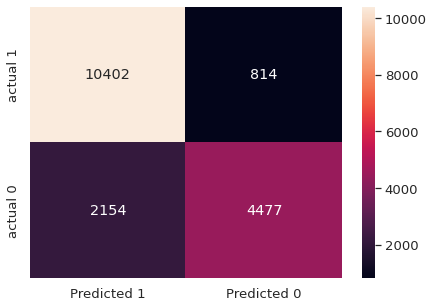

In [216]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [217]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88     11216
           1       0.85      0.68      0.75      6631

    accuracy                           0.83     17847
   macro avg       0.84      0.80      0.81     17847
weighted avg       0.84      0.83      0.83     17847



### Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
training_acc_dt=dt_model.score(X_train,y_train)
testing_acc_dt=dt_model.score(X_test,y_test)

y_predicted=dt_model.predict(X_test)

recall_dt=recall_score(y_test,y_predicted)
accuracy_dt=accuracy_score(y_test,y_predicted)
precision_dt=precision_score(y_test,y_predicted)
f1_dt=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_dt}")
print(f"Testing Accuracy : {testing_acc_dt}")

#Model is overfitting

Training Accuracy : 0.9925557716783133
Testing Accuracy : 0.7932425617750882


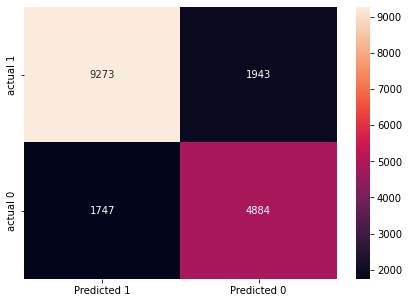

In [ ]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [ ]:

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     11216
           1       0.72      0.74      0.73      6631

    accuracy                           0.79     17847
   macro avg       0.78      0.78      0.78     17847
weighted avg       0.79      0.79      0.79     17847



### RandomForest

In [ ]:
rf_model = RandomForestClassifier( )
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
training_acc_rf=rf_model.score(X_train,y_train)
testing_acc_rf=rf_model.score(X_test,y_test)

y_predicted=rf_model.predict(X_test)

recall_rf=recall_score(y_test,y_predicted)
accuracy_rf=accuracy_score(y_test,y_predicted)
precision_rf=precision_score(y_test,y_predicted)
f1_rf=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_rf}")
print(f"Testing Accuracy : {testing_acc_rf}")

#Model is overfitting

Training Accuracy : 0.9925557716783133
Testing Accuracy : 0.848209783156833


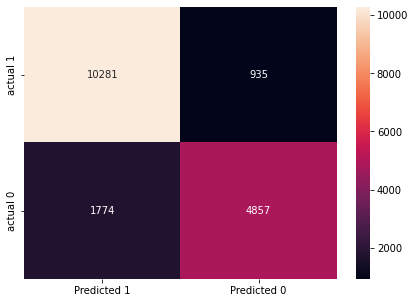

In [ ]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     11216
           1       0.84      0.73      0.78      6631

    accuracy                           0.85     17847
   macro avg       0.85      0.82      0.83     17847
weighted avg       0.85      0.85      0.85     17847



### SVC

In [ ]:
svc_model = SVC( )
svc_model.fit(X_train,y_train)

SVC()

In [ ]:
training_acc_svc=svc_model.score(X_train,y_train)
testing_acc_svc=svc_model.score(X_test,y_test)

y_predicted=svc_model.predict(X_test)

recall_svc=recall_score(y_test,y_predicted)
accuracy_svc=accuracy_score(y_test,y_predicted)
precision_svc=precision_score(y_test,y_predicted)
f1_svc=f1_score(y_test,y_predicted)

print(f"Training Accuracy : {training_acc_svc}")
print(f"Testing Accuracy : {testing_acc_svc}")

#Model is not overfitting

Training Accuracy : 0.6854933602286098
Testing Accuracy : 0.6825236734465177


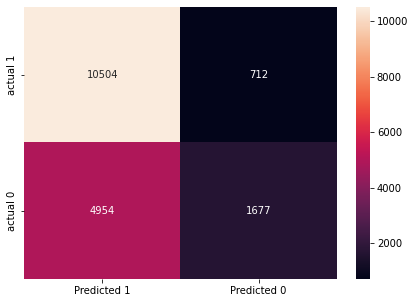

In [ ]:

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.68      0.94      0.79     11216
           1       0.70      0.25      0.37      6631

    accuracy                           0.68     17847
   macro avg       0.69      0.59      0.58     17847
weighted avg       0.69      0.68      0.63     17847




#  Comparing Each Models Evaluation Matrix

In [ ]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [ ]:
evaluation_matrix_base = {
    'Logistic Regression': [accuracy_lreg, recall_lreg, precision_lreg, f1_lreg],
    'SVC':[accuracy_svc,recall_svc,precision_svc, f1_svc],
    'Decision Tree':[accuracy_dt, recall_dt, precision_dt, f1_dt],
    'Random Forest':[accuracy_rf, recall_rf, precision_rf, f1_rf],
    'XGB':[accuracy_xgb, recall_xgb, precision_xgb, f1_xgb],
    'LGB':[accuracy_lgb, recall_lgb, precision_lgb, f1_lgb],

}


eva_base = pd.DataFrame(data = evaluation_matrix_base, index = ['Accuracy', 'Recall', 'Precision', 'F1 Score'])

evaluation_matrix_base_training = {
    "training" : [training_acc_lreg, training_acc_svc, training_acc_dt, training_acc_rf, training_acc_xgb,training_acc_lgb],
    "testing": [testing_acc_lreg, testing_acc_svc, testing_acc_dt, testing_acc_rf, testing_acc_xgb,testing_acc_lgb]
}
    

eva_base_train = pd.DataFrame(data = evaluation_matrix_base_training, index = ['Logistic Regresion', 'SVC', 'Decision Tree', 'Random Forest', 'XGB','LGB'])

print()
display_side_by_side([eva_base], ['Evaluation Matrix'])
print("\n")
display_side_by_side([eva_base_train], ['Accuracy Train & Test'])



,Logistic Regression,SVC,Decision Tree,Random Forest,XGB
Accuracy,0.797221,0.682524,0.793243,0.848210,0.818905
Recall,0.565676,0.252903,0.736540,0.732469,0.623586
Precision,0.835412,0.701967,0.715395,0.838570,0.848902
F1 Score,0.674580,0.371840,0.725814,0.781937,0.719005


,training,testing
Logistic Regresion,0.790049,0.797221
SVC,0.685493,0.682524
Decision Tree,0.992556,0.793243
Random Forest,0.992556,0.848210
XGB,0.813846,0.818905


# Applying Hyper Parameter Tuning using Grid SeachCV for  alogorithms to check best score and best parameters


In [ ]:
from sklearn.model_selection import GridSearchCV
met_grid= {"F1": "f1", "Accuracy": "accuracy"}


### XGB

In [ ]:
param_grid ={'max_depth':[6,8,10,12],'learning_rate': [0.3, 0.5, 0.7],'gamma': [0,1,2,3]}
clf_xgb = GridSearchCV(estimator= xgb, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_xgb = clf_xgb.fit(X_train,y_train)
print('XGBOOST Best score: {} using best parameters {}'.format(best_clf_xgb.best_score_, best_clf_xgb.best_params_))

XGBOOST Best score: 0.833345340153207 using best parameters {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 8}


In [ ]:
XGB_tuned = clf_xgb.best_estimator_
acc_XGB_tuned_train = clf_xgb.best_score_
y_pred_XGB_tuned = XGB_tuned.predict(X_test)
acc_XGB_tuned_test = accuracy_score(y_test, y_pred_XGB_tuned)
f1_XGB_tuned = f1_score(y_test, y_pred_XGB_tuned)


print(f"Training Accuracy : {acc_XGB_tuned_train}")
print(f"Testing Accuracy : {acc_XGB_tuned_test}")
print(f"F1 Score : {f1_XGB_tuned}")


Training Accuracy : 0.833345340153207
Testing Accuracy : 0.8423824732448031
F1 Score : 0.7719497365220916


### LGB

In [224]:
param_grid ={'n_estimators':[10, 50, 100,500],'learning_rate': [0.0001, 0.001, 0.01, 0.1,1],'max_depth': [1,3,4,5]}
clf_lgb = GridSearchCV(estimator= lgb_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_lgb = clf_lgb.fit(X_train,y_train)
print('LGB Best score: {} using best parameters {}'.format(best_clf_lgb.best_score_, best_clf_lgb.best_params_))

LGB Best score: 0.8314962898926591 using best parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [225]:
LGB_tuned = clf_lgb.best_estimator_
acc_LGB_tuned_train = clf_lgb.best_score_
y_pred_LGB_tuned = LGB_tuned.predict(X_test)
acc_LGB_tuned_test = accuracy_score(y_test, y_pred_LGB_tuned)
f1_LGB_tuned = f1_score(y_test, y_pred_LGB_tuned)


print(f"Training Accuracy : {acc_LGB_tuned_train}")
print(f"Testing Accuracy : {acc_LGB_tuned_test}")
print(f"F1 Score : {f1_LGB_tuned}")


Training Accuracy : 0.8314962898926591
Testing Accuracy : 0.8382361181150894
F1 Score : 0.7618576260001649


### Random Forest

In [ ]:

param_grid = [{'min_samples_split': [2,3,4,6,8,10],'max_depth': [12,14,18,20],'min_samples_leaf': [1,2,4,8]}]

clf_rf = GridSearchCV(estimator= rf_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_rf = clf_rf.fit(X_train,y_train)
print(' Random Forest Best  score: {} using best parameters {}'.format(best_clf_rf.best_score_, best_clf_rf.best_params_))

 Random Forest Best  score: 0.8372595634320295 using best parameters {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
RF_tuned = clf_rf.best_estimator_
acc_RF_tuned_train = clf_rf.best_score_
y_pred_RF_tuned = RF_tuned.predict(X_test)

acc_RF_tuned_test = accuracy_score(y_test, y_pred_RF_tuned)
f1_RF_tuned = f1_score(y_test, y_pred_RF_tuned)


print(f"Training Accuracy : {acc_RF_tuned_train}")
print(f"Testing Accuracy : {acc_RF_tuned_test}")
print(f"F1 Score : {f1_RF_tuned}")


Training Accuracy : 0.8372595634320295
Testing Accuracy : 0.8437832688967334
F1 Score : 0.7680918316419897


### Logistic Regresion

In [ ]:

param_grid = [{'penalty': ['l2','l1','elasticent'],'C': [1.0, 2.0, 3.0, 5,0.5, 0.1],'class_weight': [None, 'balanced'],'max_iter': [500,2000,4000]}]
clf_lgr = GridSearchCV(estimator= lreg, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_lgr = clf_lgr.fit(X_train,y_train)
print('Logistic Regression Best score: {} using best parameters {}'.format(best_clf_lgr.best_score_, best_clf_lgr.best_params_))

Logistic Regression Best score: 0.8024397857983333 using best parameters {'C': 2.0, 'class_weight': None, 'max_iter': 2000, 'penalty': 'l2'}


In [ ]:
LGR_tuned = clf_lgr.best_estimator_
acc_LGR_tuned_train = clf_lgr.best_score_
y_pred_LGR_tuned = LGR_tuned.predict(X_test)
acc_LGR_tuned_test = accuracy_score(y_test, y_pred_LGR_tuned)
f1_LGR_tuned = f1_score(y_test, y_pred_LGR_tuned)


print(f"Training Accuracy : {acc_LGR_tuned_train}")
print(f"Testing Accuracy : {acc_LGR_tuned_test}")
print(f"F1 Score : {f1_LGR_tuned}")


Training Accuracy : 0.8024397857983333
Testing Accuracy : 0.8105003642068696
F1 Score : 0.7017110601517023


### Decision Tree

In [ ]:

param_grid = [{'min_samples_split': [2,1,3,4,6,8,10],'max_depth': [None,1,2,4,8,10,12,14,16],'min_samples_leaf': [1,2,4,5,8]}]

clf_dt = GridSearchCV(estimator= dt_model, param_grid = param_grid, cv = 3, n_jobs=-1, scoring=met_grid ,refit='Accuracy')
best_clf_dt = clf_dt.fit(X_train,y_train)
print('Decision Tree Best score: {} using best parameters {}'.format(best_clf_dt.best_score_, best_clf_dt.best_params_))

Decision Tree Best score: 0.8153351103426747 using best parameters {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [ ]:
DT_tuned = clf_dt.best_estimator_
acc_DT_tuned_train = clf_dt.best_score_
y_pred_DT_tuned = DT_tuned.predict(X_test)
acc_DT_tuned_test = accuracy_score(y_test, y_pred_DT_tuned)
f1_DT_tuned = f1_score(y_test, y_pred_DT_tuned)


print(f"Training Accuracy : {acc_DT_tuned_train}")
print(f"Testing Accuracy : {acc_DT_tuned_test}")
print(f"F1 Score : {f1_DT_tuned}")


Training Accuracy : 0.8153351103426747
Testing Accuracy : 0.8226032386395472
F1 Score : 0.7347520107238606


# Comparing Tuned Models

In [ ]:
evaluation_matrix_tuned = {
    "Training Accuracy" : [acc_LGR_tuned_train, acc_DT_tuned_train, acc_RF_tuned_train, acc_XGB_tuned_train,acc_LGB_tuned_train],
    "Testing Accuracy": [acc_LGR_tuned_test, acc_DT_tuned_test, acc_RF_tuned_test, acc_XGB_tuned_test,acc_LGB_tuned_test],
    "F1": [f1_LGR_tuned, f1_DT_tuned, f1_RF_tuned, f1_XGB_tuned]

}

eva_tuned = pd.DataFrame(data = evaluation_matrix_tuned, index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGB','LGB'])


In [ ]:
display_side_by_side([ eva_tuned], ['Tuned Models'])


,Training Accuracy,Testing Accuracy,F1
Logistic Regression,0.807098,0.801871,0.682756
Decision Tree,0.818457,0.814591,0.723258
Random Forest,0.842495,0.845016,0.771481
XGB,0.837188,0.840029,0.770959


# Applying StratifiedKfold Cross Validation Technique on top 3 algorithms to know the exact mean CV accuracy score of the models



Input the best parameters obtained in hyper tuning tuning for respective alogorithms

In [ ]:
from sklearn.model_selection import cross_val_score,StratifiedKFold,cross_validate
skfold = StratifiedKFold(n_splits= 5,shuffle= True,random_state= 42)


### XGB

In [ ]:
xgb_model=XGBClassifier(gamma= 0, learning_rate=0.3, max_depth= 8)

xgb_cv_result_acc = cross_val_score(xgb_model,X, y, cv=skfold, scoring="accuracy",n_jobs=-1)
xgb_cv_acc = xgb_cv_result_acc.mean()*100

xgb_cv_result_f1 = cross_val_score(xgb_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
xgb_cv_f1 = xgb_cv_result_f1.mean()*100
print('XGBOOST CV Mean Accuracy Score is {}'.format(xgb_cv_acc))
print('XGBOOST CV F1 Score is {}'.format(xgb_cv_f1))

XGBOOST CV Mean Accuracy Score is 84.00067238191292
XGBOOST CV F1 Score is 76.73924678953213


              precision    recall  f1-score   support

           0       0.85      0.92      0.88     11216
           1       0.83      0.72      0.77      6631

    accuracy                           0.84     17847
   macro avg       0.84      0.82      0.83     17847
weighted avg       0.84      0.84      0.84     17847



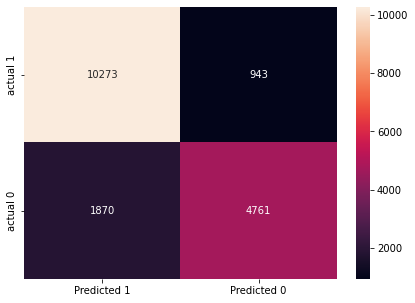

In [ ]:
xgb_model.fit(X_train,y_train)
y_predicted=xgb_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### LGB

In [233]:
lgb_model=lgb.LGBMClassifier(learning_rate=0.1, max_depth= 5, n_estimators=500)

lgb_cv_result_acc = cross_val_score(lgb_model,X, y, cv=skfold, scoring="accuracy",n_jobs=-1)
lgb_cv_acc = lgb_cv_result_acc.mean()*100

lgb_cv_result_f1 = cross_val_score(xgb_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
lgb_cv_f1 = lgb_cv_result_f1.mean()*100
print('LGB CV Mean Accuracy Score is {}'.format(lgb_cv_acc))
print('LGB CV F1 Score is {}'.format(lgb_cv_f1))

LGB CV Mean Accuracy Score is 83.80736258194655
LGB CV F1 Score is 77.47956502668242


              precision    recall  f1-score   support

           0       0.84      0.92      0.88     11216
           1       0.84      0.70      0.76      6631

    accuracy                           0.84     17847
   macro avg       0.84      0.81      0.82     17847
weighted avg       0.84      0.84      0.83     17847



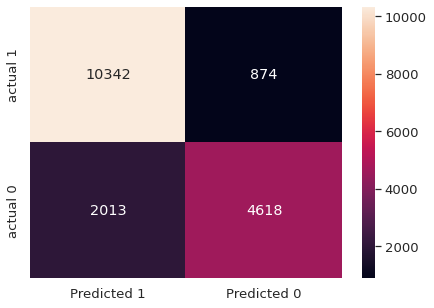

In [228]:
lgb_model.fit(X_train,y_train)
y_predicted=lgb_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Decision Tree

In [ ]:
dt_model=DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 1, min_samples_split= 4)

dt_cv_result_acc = cross_val_score(dt_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
dt_cv_acc = dt_cv_result_acc.mean()*100
print('DecisionTree CV Mean Accuracy Score is {}'.format(dt_cv_acc))

dt_cv_result_f1 = cross_val_score(dt_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
dt_cv_f1 = dt_cv_result_f1.mean()*100
print('DecisionTree CV F1 Score  is {}'.format(dt_cv_f1))

DecisionTree CV Mean Accuracy Score is 81.7683644309968
DecisionTree CV F1 Score  is 72.26111821862663


              precision    recall  f1-score   support

           0       0.82      0.92      0.87     11216
           1       0.83      0.66      0.73      6631

    accuracy                           0.82     17847
   macro avg       0.82      0.79      0.80     17847
weighted avg       0.82      0.82      0.82     17847



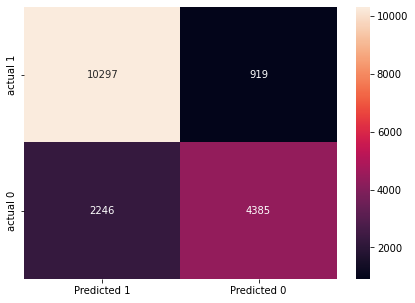

In [ ]:
dt_model.fit(X_train,y_train)
y_predicted=dt_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Random Forest

In [ ]:
rf_model=RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split=2)

rf_cv_result_acc = cross_val_score(rf_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
rf_cv_acc = rf_cv_result_acc.mean()*100
print('Random Forest CV Mean Accuracy Score is {}'.format(rf_cv_acc))

rf_cv_result_f1 = cross_val_score(rf_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
rf_cv_f1 = rf_cv_result_f1.mean()*100
print('Random Forest CV F1 Score  is {}'.format(rf_cv_f1))

Random Forest CV Mean Accuracy Score is 84.27298705664818
Random Forest CV F1 Score  is 76.6031252617571


              precision    recall  f1-score   support

           0       0.84      0.93      0.88     11216
           1       0.86      0.70      0.77      6631

    accuracy                           0.84     17847
   macro avg       0.85      0.81      0.83     17847
weighted avg       0.85      0.84      0.84     17847



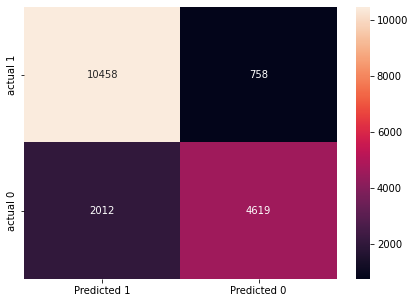

In [ ]:
rf_model.fit(X_train,y_train)
y_predicted=rf_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


### Logistic Regresion

In [ ]:
lrg_model=LogisticRegression(C= 2, max_iter= 2000, penalty='l2', solver= 'lbfgs',class_weight= None)

lrg_cv_result_acc = cross_val_score(lrg_model,X, y, cv=skfold,scoring="accuracy",n_jobs=-1)
lrg_cv_acc = lrg_cv_result_acc.mean()*100
print('Logistic Regression  CV Mean Accuarcy Score is {}'.format(lrg_cv_acc))

lrg_cv_result_f1 = cross_val_score(lrg_model,X, y, cv=skfold,scoring="f1",n_jobs=-1)
lrg_cv_f1 = lrg_cv_result_f1.mean()*100
print('Logistic Regression CV Mean F1 Score is {}'.format(lrg_cv_f1))

Logistic Regression  CV Mean Accuarcy Score is 80.54631030425283
Logistic Regression CV Mean F1 Score is 69.40532826056362


              precision    recall  f1-score   support

           0       0.80      0.94      0.86     11216
           1       0.85      0.60      0.70      6631

    accuracy                           0.81     17847
   macro avg       0.82      0.77      0.78     17847
weighted avg       0.82      0.81      0.80     17847



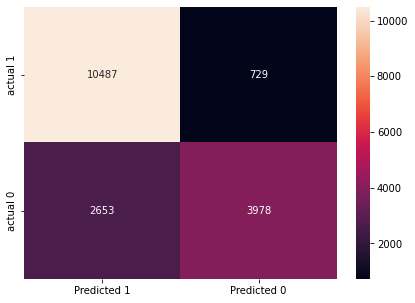

In [ ]:
lrg_model.fit(X_train,y_train)
y_predicted=lrg_model.predict(X_test)

cm=confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(data = cm, index = ['actual 1', 'actual 0'], columns = ['Predicted 1', 'Predicted 0'])


plt.figure(figsize = (7, 5))
sns.heatmap(df_stacked_model, annot = True,fmt='g')

print(classification_report(y_test, y_predicted))


# Plotting Dataframe to present the mean CV  scores of the Models


In [ ]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores_acc = pd.DataFrame(data=[('Random Forest',rf_cv_acc), 
                                             ('Decision Tree',dt_cv_acc),('XGBClassifier',xgb_cv_acc),('Logistic Regression',lrg_cv_acc)
                                             ],
                                       columns=['Model', 'CV_Accuracy_Score', ])
predictive_model_scores_acc

,Model,CV_Accuracy_Score
0,Random Forest,84.272987
1,Decision Tree,81.768364
2,XGBClassifier,84.000672
3,Logistic Regression,80.546310


In [ ]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores_f1 = pd.DataFrame(data=[('Random Forest',rf_cv_f1), 
                                             ('Decision Tree',dt_cv_f1),('XGBClassifier',xgb_cv_f1),('Logistic Regression',lrg_cv_f1)],
                                       columns=['Model', 'CV_F1_Score', ])
predictive_model_scores_f1

,Model,CV_F1_Score
0,Random Forest,76.603125
1,Decision Tree,72.261118
2,XGBClassifier,76.739247
3,Logistic Regression,69.405328


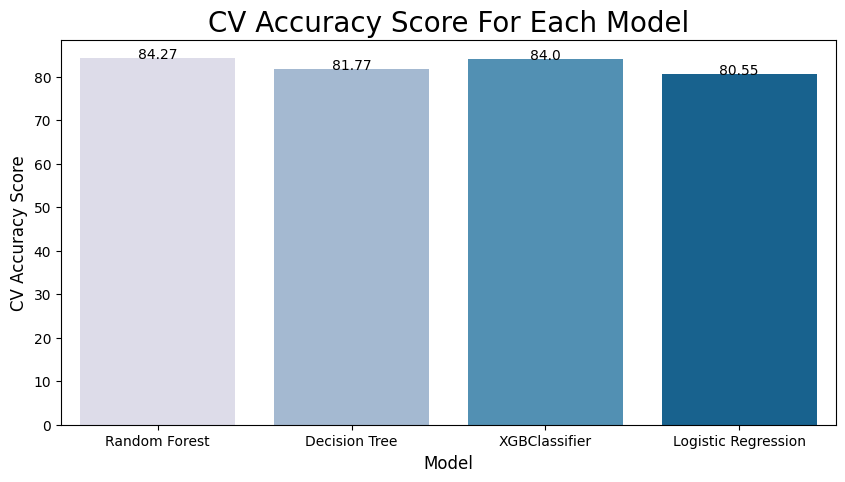

In [ ]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='Model', y='CV_Accuracy_Score', data=predictive_model_scores_acc, palette='PuBu')
plt.title('CV Accuracy Score For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('CV Accuracy Score', fontsize = 12)
for index, row in predictive_model_scores_acc.iterrows():
    p.text(x=row.name, y=row.CV_Accuracy_Score, s=round(row.CV_Accuracy_Score,2), color='black', horizontalalignment='center');

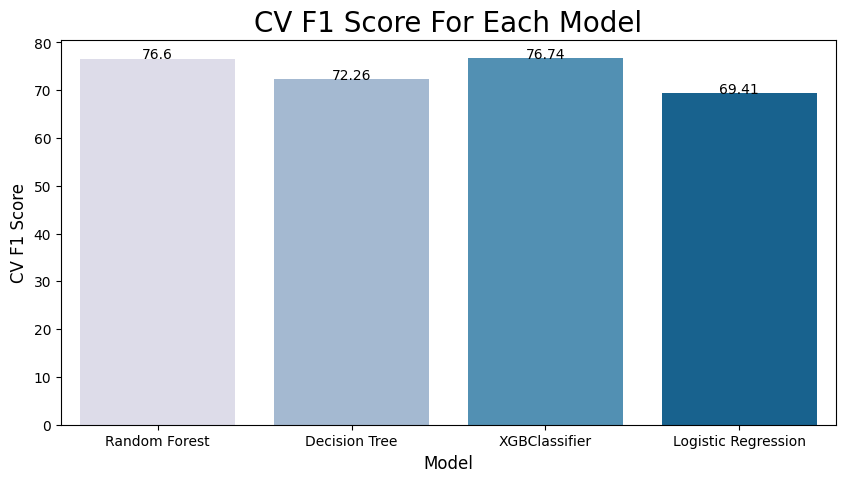

In [ ]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='Model', y='CV_F1_Score', data=predictive_model_scores_f1, palette='PuBu')
plt.title('CV F1 Score For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('CV F1 Score', fontsize = 12)
for index, row in predictive_model_scores_f1.iterrows():
    p.text(x=row.name, y=row.CV_F1_Score, s=round(row.CV_F1_Score,2), color='black', horizontalalignment='center');

# Building Stacked Model

In [283]:
# Define estimators
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# DecisionTreeClassifier
skfold = StratifiedKFold(n_splits= 5,shuffle= True,random_state= 42)

xgb_model=XGBClassifier(gamma= 0, learning_rate=0.3, max_depth= 12)
rf_model=RandomForestClassifier(max_depth= None, max_leaf_nodes= None, min_samples_leaf= 1, min_samples_split=4)
dt_model=DecisionTreeClassifier(max_depth= 12, min_samples_leaf= 8, min_samples_split= 4)
lrg_model=LogisticRegression(C= 2, max_iter= 2000, penalty='l2', solver= 'lbfgs')
lgb_model=lgb.LGBMClassifier(learning_rate=0.1, max_depth= 4, n_estimators=50)
# lgb_model=lgb.LGBMClassifier(learning_rate=0.1, max_depth= 5, n_estimators=500)

estimator_list = [
 ('rf_model' , rf_model),
 ('dt_model' , dt_model),

]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression(), cv=skfold
)

# # Train stacked model
# stack_model.fit(X_train, y_train)


In [287]:
scr_acc = cross_val_score(stack_model, X, y, scoring='accuracy', cv=skfold, n_jobs=-1)
scr_f1 = cross_val_score(stack_model, X, y, scoring='f1', cv=skfold, n_jobs=-1)


In [289]:
scr_cv_acc = scr_acc.mean()*100
scr_cv_f1 = scr_f1.mean()*100

print('Stacked Model CV Mean Accuracy Score is {}'.format(scr_cv_acc))
print('Stacked Model CV Mean F1 Score is {}'.format(scr_cv_f1))

Stacked Model CV Mean Accuracy Score is 84.90334510001681
Stacked Model CV Mean F1 Score is 78.05418257362587


### ROC Curve

In [285]:
from sklearn.metrics import roc_curve, roc_auc_score


classifiers=[stack_model]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train.values, y_train.values)
    yproba = model.predict_proba(X_test.values)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test.values,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)





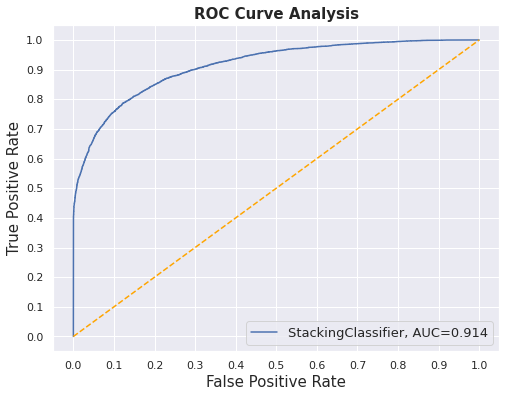

In [273]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig = plt.figure(figsize=(8,6))


for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [200]:
y_predicted=stack_model.predict(X_test.values)
cm_stacked_model = confusion_matrix(y_test, y_predicted)
df_stacked_model = pd.DataFrame(cm_stacked_model, index=[' Not Cancelled',  'Cancelled'],
                 columns=[' Not Cancelled', ' Cancelled'])


              precision    recall  f1-score   support

           0       0.85      0.92      0.88     11216
           1       0.84      0.73      0.78      6631

    accuracy                           0.85     17847
   macro avg       0.85      0.82      0.83     17847
weighted avg       0.85      0.85      0.85     17847



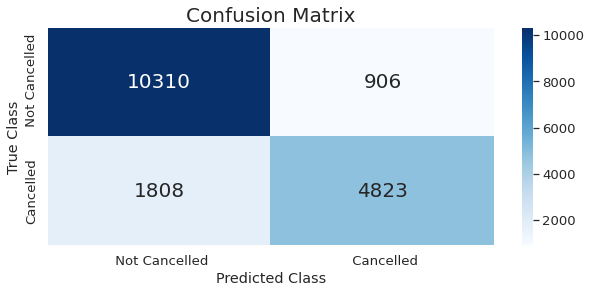

In [201]:

# visualizing the confusion matrix
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(df_stacked_model, annot=True, fmt='g', cmap="Blues",xticklabels=df_stacked_model.columns, yticklabels=df_stacked_model.index, annot_kws={"size": 20})
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');

print(classification_report(y_test, y_predicted))

### Test the model for few properties


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17847 entries, 49698 to 66454
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   lead_time                      17847 non-null  int64  
 1   arrival_date_day_of_month      17847 non-null  int64  
 2   previous_cancellations         17847 non-null  int64  
 3   booking_changes                17847 non-null  int64  
 4   adr                            17847 non-null  float64
 5   required_car_parking_spaces    17847 non-null  int64  
 6   total_of_special_requests      17847 non-null  int64  
 7   total_stays                    17847 non-null  int64  
 8   arrival_date_month_April       17847 non-null  int64  
 9   arrival_date_month_August      17847 non-null  int64  
 10  arrival_date_month_December    17847 non-null  int64  
 11  arrival_date_month_February    17847 non-null  int64  
 12  arrival_date_month_January     17847 non-n

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59490 entries, 93460 to 115764
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   lead_time                      59490 non-null  int64  
 1   arrival_date_day_of_month      59490 non-null  int64  
 2   previous_cancellations         59490 non-null  int64  
 3   booking_changes                59490 non-null  int64  
 4   adr                            59490 non-null  float64
 5   required_car_parking_spaces    59490 non-null  int64  
 6   total_of_special_requests      59490 non-null  int64  
 7   total_stays                    59490 non-null  int64  
 8   arrival_date_month_April       59490 non-null  int64  
 9   arrival_date_month_August      59490 non-null  int64  
 10  arrival_date_month_December    59490 non-null  int64  
 11  arrival_date_month_February    59490 non-null  int64  
 12  arrival_date_month_January     59490 non-

In [242]:
def predict_cancellation(arrival_date_month,arrival_date_day_of_month,total_stays,booking_changes,required_car_parking_spaces,customer_type,adr,previous_cancellations,market_segment,total_of_special_requests,lead_time,deposit_type):    
    customer_type_index = np.where(X.columns=='customer_type_'+customer_type)[0][0]
    market_segment_index = np.where(X.columns=='market_segment_'+market_segment)[0][0]
    deposit_type_index = np.where(X.columns=='deposit_type_'+deposit_type)[0][0]
    arrival_date_month_index = np.where(X.columns=='arrival_date_month_'+arrival_date_month)[0][0]


    x = np.zeros(len(X.columns))
    x[1] = arrival_date_day_of_month
    x[7] = total_stays
    x[3] = booking_changes
    x[5] = required_car_parking_spaces
    x[2] = previous_cancellations
    x[6] = total_of_special_requests
    x[4] = adr
    x[0] = lead_time

  


    if customer_type_index >= 0:
        x[customer_type_index] = 1

    if market_segment_index >= 0:
        x[market_segment_index] = 1

    if deposit_type_index >= 0:
        x[deposit_type_index] = 1
    
    if arrival_date_month_index >= 0:
        x[arrival_date_month_index] = 1
  

    
    return stack_model.predict([x])[0],stack_model.predict_proba([x])






In [243]:
print(predict_cancellation('March',1,4,2,1,'Group',34,20,'Complementary',1,223,'No Deposit'))

(1, array([[4.72502597e-04, 9.99527497e-01]]))


In [ ]:
X_train.columns.values.tolist() 

### Export the tested model to a pickle file


In [286]:
import pickle
with open('hotel_booking_cancellation_model3.pickle','ab') as f:
    pickle.dump(stack_model,f)

In [208]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}

with open("data_columns.json","w") as f:
    f.write(json.dumps(columns))